In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current Device Index:", torch.cuda.current_device())
else:
    print("No GPU detected.")

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4080
Current Device Index: 0


In [2]:
names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ---------------------------------------- 3/3 [imblearn]



In [2]:
!pip install transformers datasets accelerate torch

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached huggingface_hub-0.31.2-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.11.18-cp310-cp310-win_amd64.whl.metadata (8.0 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached huggingface_hub-0.31.2-py3-none-any.whl (484 kB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
Using cached accelerate-1.6.0-py3-none-any.whl (354 kB)
Using c

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split


C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing Multivariate to Multivariate BatchTST on Amman

In [67]:
!pip install transformers datasets accelerate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 8.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/10.4 MB 10.8 MB/s eta 0:00:01
   --------------------------- ------------ 7.1/10.4 MB 13.2 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.4 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 15.4 MB/s eta 0:00:00

   -------- -------------------------------  2/10 [regex]
   ------------ ---------------------------  3/10 [dill]
   ---------------- -----------------------  4/10 [multiprocess]
   -------------------- -------------------  5/10 [huggingface-hub]
   -------------------- -------------------  5/10 [huggingface-hub]
   -

In [36]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)

#cyclical features
   
df['month'] = df.index.month
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Define target variables
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']

series = TimeSeries.from_dataframe(df, value_cols=target_cols)

In [37]:


#Config parameters
input_length = 96 
forecast_horizon = 48  
batch_size = 16
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

#Targets and inputs
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos','dow_sin', 'dow_cos']
input_cols = target_cols + cyclical_cols

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[input_cols])
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=input_cols)
data_np = scaled_df.values

Using: cuda


In [38]:
class WeatherDataset(Dataset):
    def __init__(self, data, input_len, forecast_len):
        self.data = data
        self.input_len = input_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.data) - self.input_len - self.forecast_len

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.input_len]
        target_seq = self.data[idx + self.input_len : idx + self.input_len + self.forecast_len, :6]  # only targets
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

train_size = int(len(data_np) * 0.95)
train_data = data_np[:train_size]
val_data = data_np[train_size:]

train_dataset = WeatherDataset(train_data, input_length, forecast_horizon)
val_dataset = WeatherDataset(val_data, input_length, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
config = PatchTSTConfig(
    context_length=96, # input 96 hours and output 48 hours
    prediction_length=48,
    patch_length=24,
    stride=12,
    num_input_channels=12,  
    target_dim=6,          
    target_names=['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V'],  
    d_model=128,
    n_heads=8,
    num_layers=5,
    dropout=0.1
)

model = PatchTSTForPrediction(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.SmoothL1Loss()

In [40]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [41]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_patchtst.pt")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:13<00:00, 25.29it/s]


Epoch 1 | Train Loss: 0.2017 | Val Loss: 0.1917


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:20<00:00, 24.92it/s]


Epoch 2 | Train Loss: 0.1940 | Val Loss: 0.1913


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:13<00:00, 25.29it/s]


Epoch 3 | Train Loss: 0.1900 | Val Loss: 0.1914


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.40it/s]


Epoch 4 | Train Loss: 0.1851 | Val Loss: 0.1928


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:12<00:00, 25.35it/s]


Epoch 5 | Train Loss: 0.1790 | Val Loss: 0.1985


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.40it/s]


Epoch 6 | Train Loss: 0.1713 | Val Loss: 0.2021


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.39it/s]


Epoch 7 | Train Loss: 0.1630 | Val Loss: 0.2073
Early stopping at epoch 7


In [21]:
df_test = pd.read_csv("Amman_test_data/amman_test.csv")

In [23]:
df_test['month'] = df_test.index.month
df_test['hour'] = df_test.index.hour
df_test['dayofweek'] = df_test.index.dayofweek
df_test['dow_sin'] = np.sin(2 * np.pi * df_test['dayofweek'] / 7)
df_test['dow_cos'] = np.cos(2 * np.pi * df_test['dayofweek'] / 7)
df_test['hour_sin'] = np.sin(2 * np.pi * df_test['hour'] / 24)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['hour'] / 24)
df_test['month_sin'] = np.sin(2 * np.pi * df_test['month'] / 12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['month'] / 12)

In [22]:
df_test['time'] = pd.to_datetime(df_test['Unnamed: 0'])
df_test.set_index('time', inplace=True)



In [24]:
df_test = df_test[df_test.index > pd.to_datetime("2024-01-01")]

In [25]:
input_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
              'Atmospheric Pressure', 'Wind_U', 'Wind_V',
              'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']

scaled_test_data = scaler.transform(df_test[input_cols])

In [26]:

test_dataset = WeatherDataset(scaled_test_data, input_length, forecast_horizon)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:


model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(past_values=inputs)
        predictions = outputs[0][:, :, :6]

        all_preds.append(predictions.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

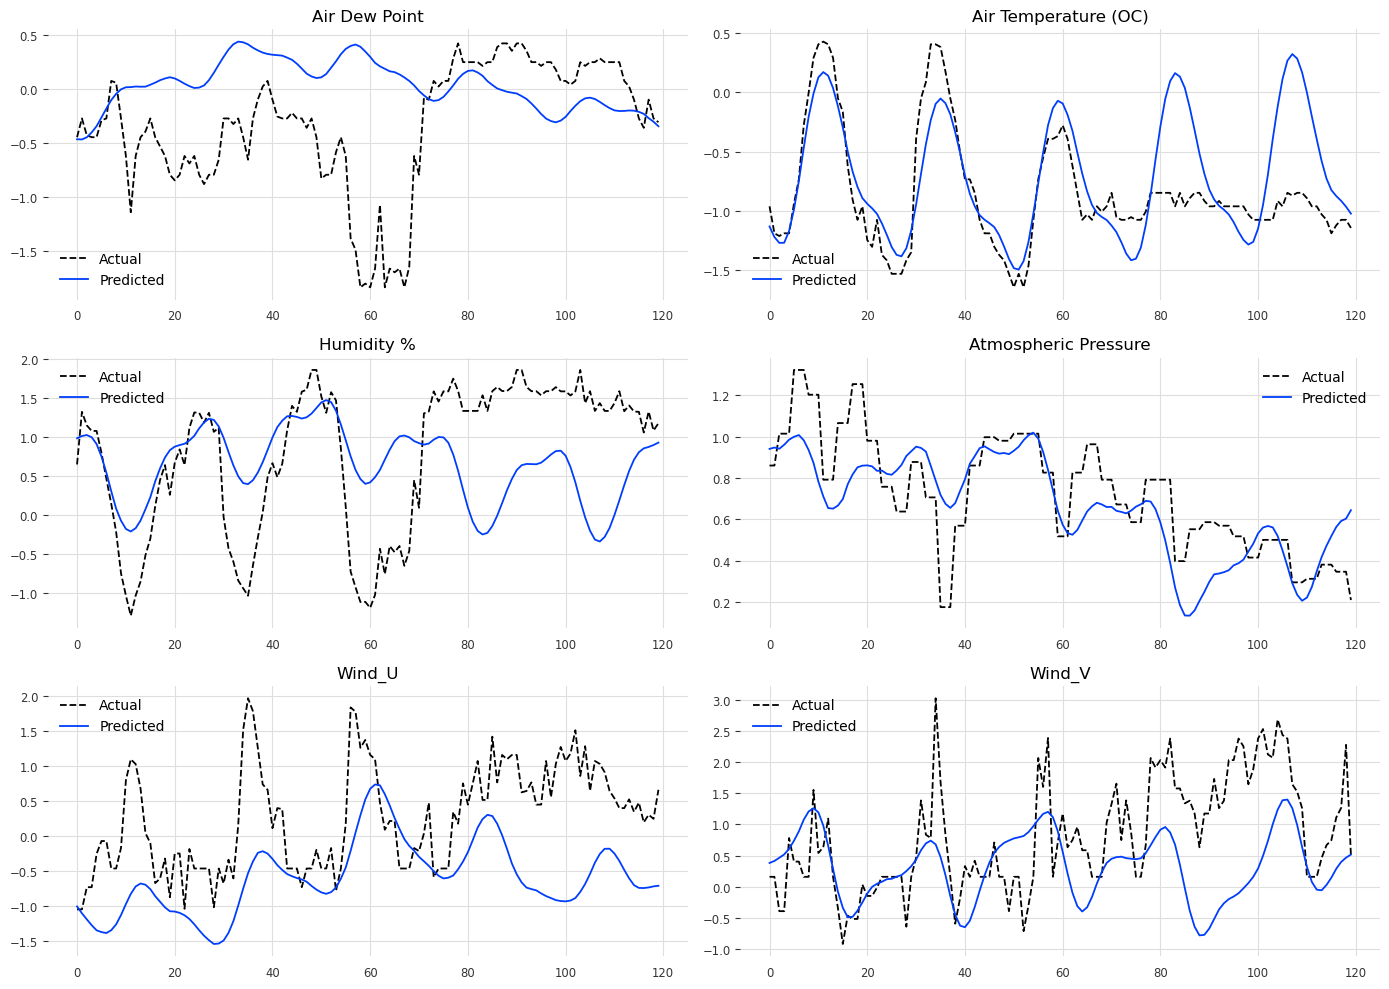

In [28]:
feature_names = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                 'Atmospheric Pressure', 'Wind_U', 'Wind_V']

sample_idx = 0  

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

for i in range(6):
    axs[i].plot(all_targets[sample_idx, :, i], label="Actual", linestyle="dashed")
    axs[i].plot(all_preds[sample_idx, :, i], label="Predicted")
    axs[i].set_title(feature_names[i])
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Multi-Variate to Uni-Variate BatchTST testing on Amman

In [63]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Liquid Precipitation  210384 non-null  float64
 6   Cloud Cover %         210384 non-null  float64
 7   Wind_U                210384 non-null  float64
 8   Wind_V                210384 non-null  float64
dtypes: float64(8), object(1)
memory usage: 14.4+ MB


In [64]:
df.drop(['Liquid Precipitation', 'Cloud Cover %'], axis = 1, inplace = True)

In [65]:
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Air Dew Point         210384 non-null  float64       
 1   Air Temperature (OC)  210384 non-null  float64       
 2   Humidity %            210384 non-null  float64       
 3   Atmospheric Pressure  210384 non-null  float64       
 4   Wind_U                210384 non-null  float64       
 5   Wind_V                210384 non-null  float64       
 6   time                  210384 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 11.2 MB


In [67]:
df.set_index(df['time'], inplace = True)


In [68]:
df.drop(['time'], axis = 1, inplace = True)

In [77]:


#Config
input_len = 72
output_len = 24
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#cyclical features
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df.drop(['day', 'month', 'hour'], axis=1, inplace=True)

#features and targets
features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_features])
df_scaled = pd.DataFrame(df_scaled, columns=all_features, index=df.index)

#Dataset

class WeatherDataset(Dataset):
    def __init__(self, df, target, input_len, output_len):
        self.X = df[all_features].values
        self.y = df[target].values
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.X) - self.input_len - self.output_len

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.input_len]
        y = self.y[idx + self.input_len : idx + self.input_len + self.output_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


#Training function

def train_patchtst(df, target_feature):
    dataset = WeatherDataset(df, target_feature, input_len, output_len)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )

    model = PatchTSTForPrediction(config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in range(10):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(-1)  # shape: [B, output_len, 1]
            outputs = model(x)  # Get the full output object
            predictions = outputs.prediction_outputs  # Access predictions directly
            loss = loss_fn(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | {target_feature} Loss: {total_loss / len(train_loader):.5f}")

    torch.save(model.state_dict(), f"patchtst_{target_feature.replace(' ', '_')}.pt")
    return model


#Train all 6 models

models = {}
for feature in features:
    print(f"\nTraining model for {feature}...\n")
    models[feature] = train_patchtst(df_scaled, target_feature=feature)


Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.57285
Epoch 2 | Air Dew Point Loss: 1.53589
Epoch 3 | Air Dew Point Loss: 1.51649
Epoch 4 | Air Dew Point Loss: 1.48378
Epoch 5 | Air Dew Point Loss: 1.46958
Epoch 6 | Air Dew Point Loss: 1.45215
Epoch 7 | Air Dew Point Loss: 1.43872
Epoch 8 | Air Dew Point Loss: 1.42210
Epoch 9 | Air Dew Point Loss: 1.41395
Epoch 10 | Air Dew Point Loss: 1.40434

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.50123
Epoch 2 | Air Temperature (OC) Loss: 1.39608
Epoch 3 | Air Temperature (OC) Loss: 1.34813
Epoch 4 | Air Temperature (OC) Loss: 1.32232
Epoch 5 | Air Temperature (OC) Loss: 1.29836
Epoch 6 | Air Temperature (OC) Loss: 1.28099
Epoch 7 | Air Temperature (OC) Loss: 1.26529
Epoch 8 | Air Temperature (OC) Loss: 1.25276
Epoch 9 | Air Temperature (OC) Loss: 1.23924
Epoch 10 | Air Temperature (OC) Loss: 1.22759

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.19878
Epoch 2 | Humidity % Loss: 1.11468
Epoch 3 | Humidity % Loss: 1.06105
Epoch 4 | Humidity % Loss: 1.04353
Epoch 5 | Humidity % Loss: 1.02322
Epoch 6 | Humidity % Loss: 1.01074
Epoch 7 | Humidity % Loss: 0.99515
Epoch 8 | Humidity % Loss: 0.98356
Epoch 9 | Humidity % Loss: 0.97401
Epoch 10 | Humidity % Loss: 0.96401

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.32213
Epoch 2 | Atmospheric Pressure Loss: 1.24045
Epoch 3 | Atmospheric Pressure Loss: 1.19226
Epoch 4 | Atmospheric Pressure Loss: 1.16514
Epoch 5 | Atmospheric Pressure Loss: 1.14627
Epoch 6 | Atmospheric Pressure Loss: 1.12450
Epoch 7 | Atmospheric Pressure Loss: 1.10494
Epoch 8 | Atmospheric Pressure Loss: 1.08834
Epoch 9 | Atmospheric Pressure Loss: 1.07639
Epoch 10 | Atmospheric Pressure Loss: 1.06094

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.49919
Epoch 2 | Wind_U Loss: 1.41726
Epoch 3 | Wind_U Loss: 1.38413
Epoch 4 | Wind_U Loss: 1.35985
Epoch 5 | Wind_U Loss: 1.35125
Epoch 6 | Wind_U Loss: 1.33547
Epoch 7 | Wind_U Loss: 1.32463
Epoch 8 | Wind_U Loss: 1.31738
Epoch 9 | Wind_U Loss: 1.30512
Epoch 10 | Wind_U Loss: 1.29642

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.44936
Epoch 2 | Wind_V Loss: 1.38145
Epoch 3 | Wind_V Loss: 1.36201
Epoch 4 | Wind_V Loss: 1.33359
Epoch 5 | Wind_V Loss: 1.32176
Epoch 6 | Wind_V Loss: 1.30652
Epoch 7 | Wind_V Loss: 1.29384
Epoch 8 | Wind_V Loss: 1.28353
Epoch 9 | Wind_V Loss: 1.27259
Epoch 10 | Wind_V Loss: 1.26893


Processing: Air Dew Point


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

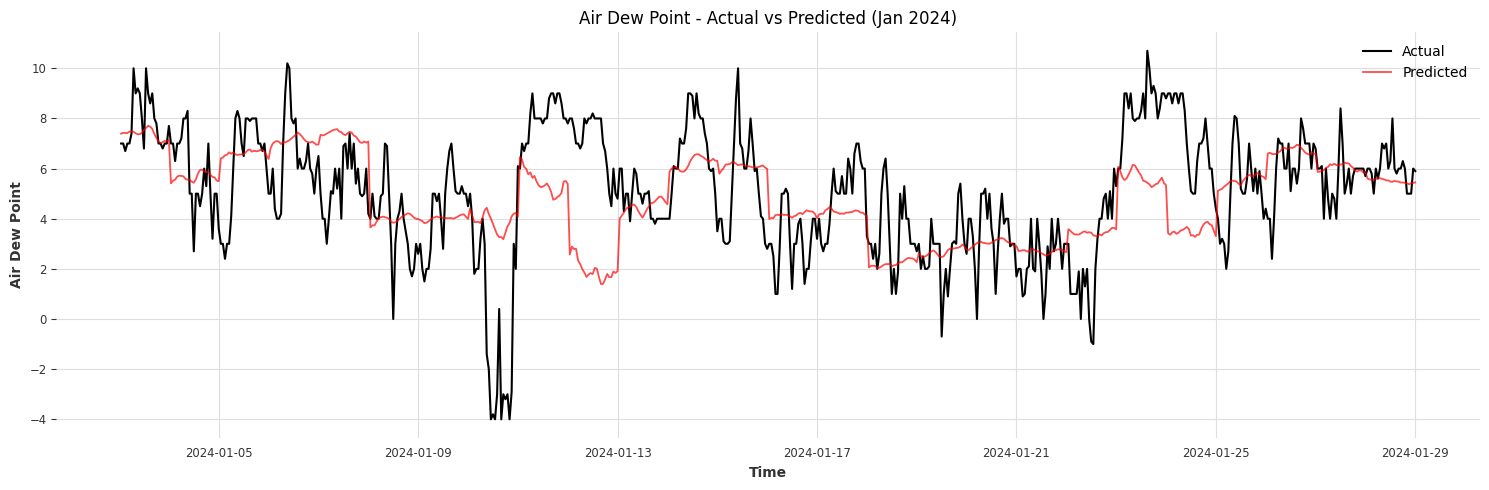

Processing: Air Temperature (OC)


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

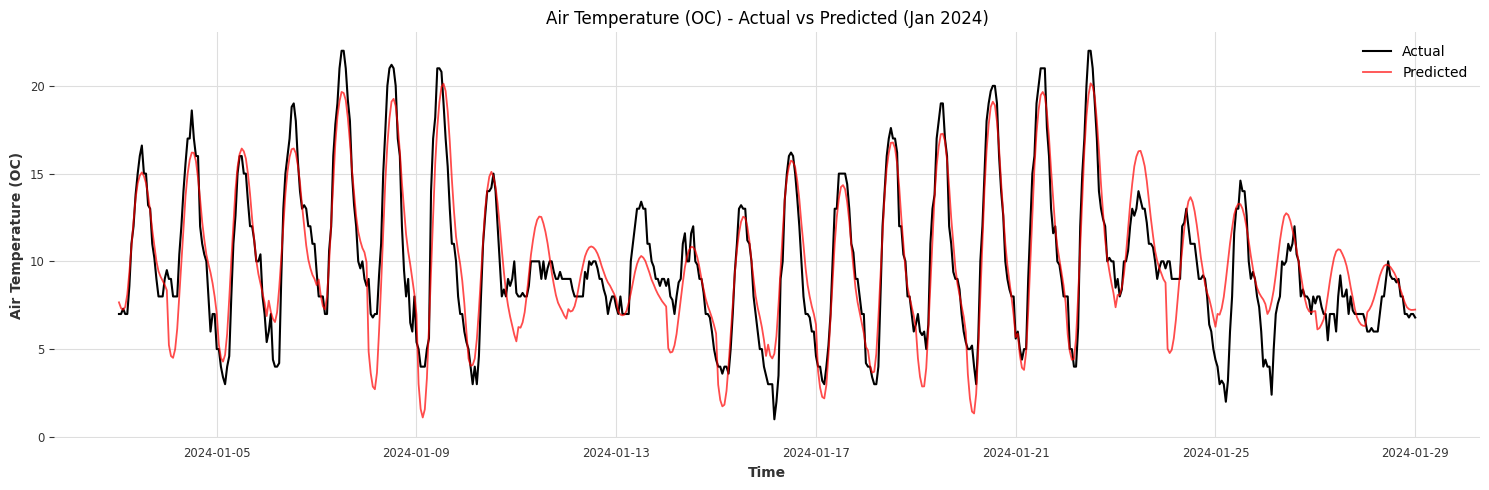

Processing: Humidity %


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

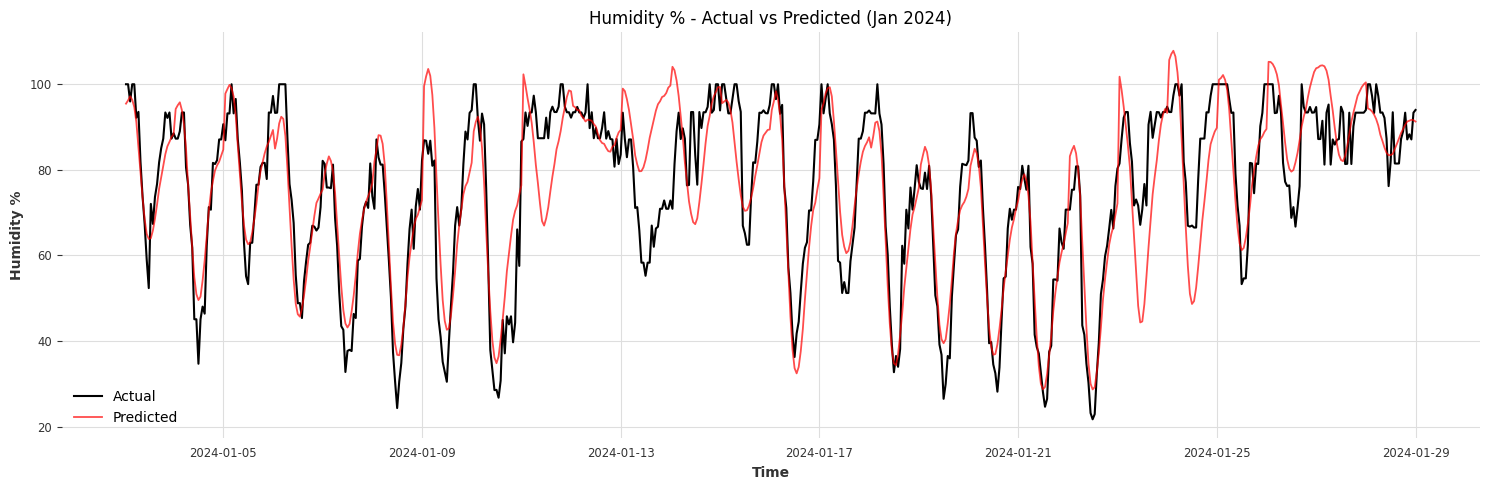

Processing: Atmospheric Pressure


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

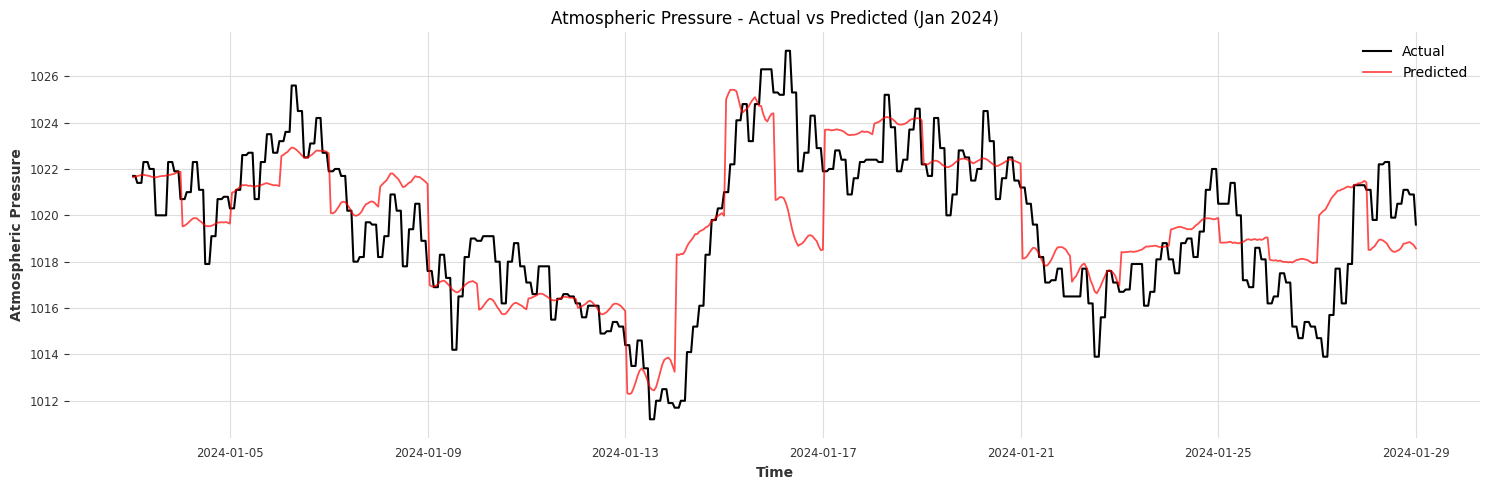

Processing: Wind_U


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

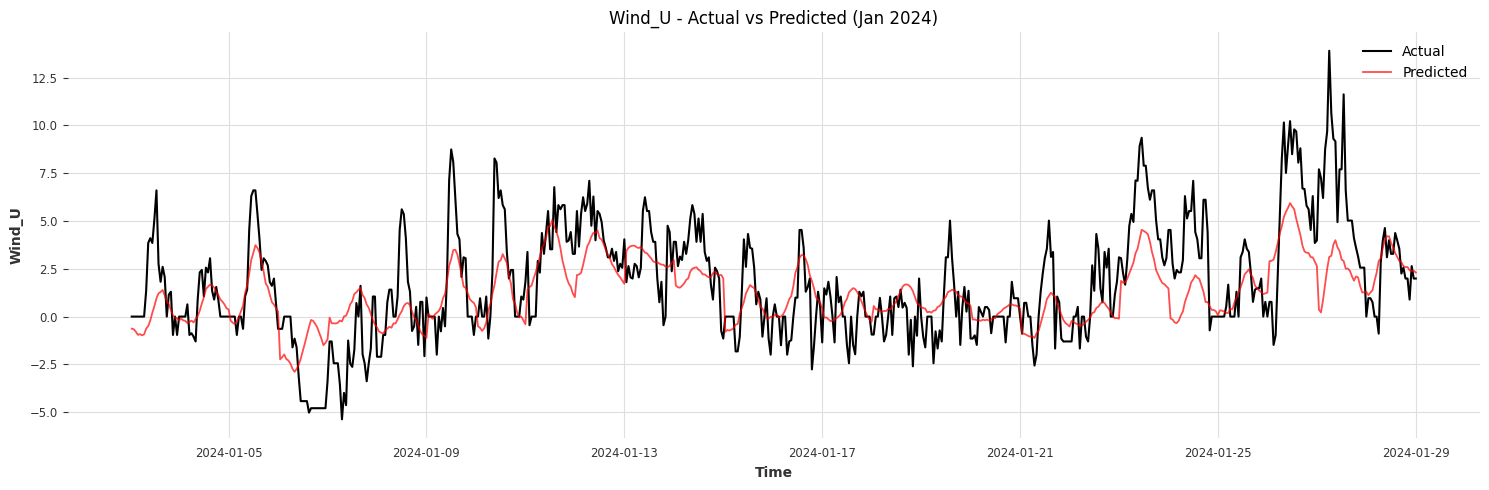

Processing: Wind_V


C:\Users\20210291\AppData\Local\Temp\ipykernel_15540\4032092477.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

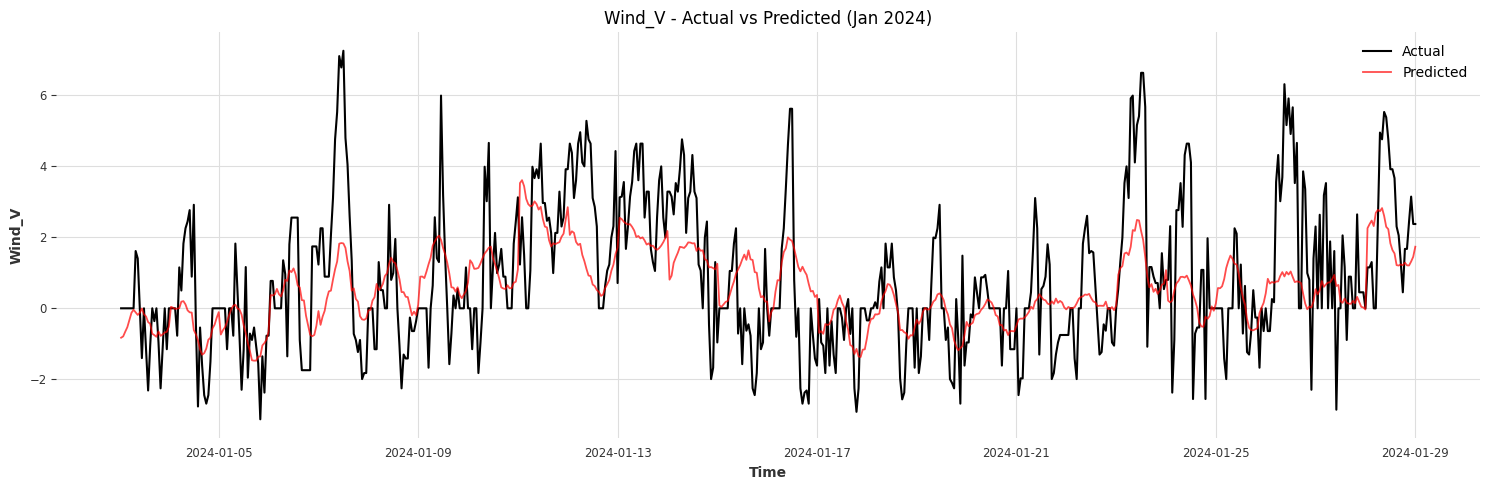

In [14]:
input_len = 72
output_len = 24
model_dir = r"Models\Other_Vars\amman"
scaler_path = os.path.join(model_dir, "amman_scaler.pkl")

features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical

scaler: StandardScaler = joblib.load(scaler_path)

test_df = pd.read_csv("Amman_test_data/amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df = test_df.set_index(test_df['time']).drop(columns=['Unnamed: 0', 'time'])



#Cyclical features
test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['hour'] = test_df.index.hour
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day'] / 31)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df.drop(['day', 'month', 'hour'], axis=1, inplace=True)
#Scale
test_scaled = scaler.transform(test_df[all_features])
test_scaled = pd.DataFrame(test_scaled, columns=all_features, index=test_df.index)
test_scaled = test_scaled[(test_scaled.index > pd.to_datetime('2024-01-01'))
    & (test_scaled.index < pd.to_datetime('2024-01-31'))]
#loop for plot
for target_feature in features:
    print(f"Processing: {target_feature}")
    
    #Load model
    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )
    model = PatchTSTForPrediction(config).to(device)
    model_path = os.path.join(model_dir, f"patchtst_{target_feature.replace(' ', '_')}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    inputs = test_scaled[all_features].values
    target_actual = test_df[target_feature].values

    predictions = []
    actuals = []
    timestamps = []

    for i in range(input_len, len(inputs) - output_len + 1, output_len):
        x = inputs[i - input_len:i]
        y_true = target_actual[i:i + output_len]

        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # [24, 12]

        y_pred_single = y_pred[:, all_features.index(target_feature)]
        y_pred_full = np.zeros((output_len, len(all_features)))
        y_pred_full[:, all_features.index(target_feature)] = y_pred_single
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]

        predictions.extend(y_pred_unscaled)
        actuals.extend(y_true)
        timestamps.extend(test_df.index[i:i + output_len])

    #Plot and save
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, actuals, label='Actual', color='black', linewidth=1.5)
    plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{target_feature} - Actual vs Predicted (Jan 2024)')
    plt.xlabel('Time')
    plt.ylabel(target_feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"{target_feature.replace(' ', '_').replace('(', '').replace(')', '')}_Jan2024_Prediction.png"
    plt.savefig(plot_filename, dpi=300)
    plt.show()

# Traning loop for all other stations

In [15]:
aqaba = pd.read_csv('Datasets-Ready/aqaba_Ready.csv')
ghor = pd.read_csv('Datasets-Ready/ghor_Ready.csv')
irbid = pd.read_csv('Datasets-Ready/irbid_Ready.csv')
irwaished = pd.read_csv('Datasets-Ready/irwaished_Ready.csv')
maan = pd.read_csv('Datasets-Ready/maan_Ready.csv')
mafraq = pd.read_csv('Datasets-Ready/mafraq_Ready.csv') 
safawi = pd.read_csv('Datasets-Ready/safawi_Ready.csv')

In [16]:
datasets = [aqaba, ghor, irbid, irwaished, maan, mafraq, safawi]
names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'safawi']

In [17]:
#Dataset

class WeatherDataset(Dataset):
    def __init__(self, df, target, input_len, output_len):
        self.X = df[all_features].values
        self.y = df[target].values
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.X) - self.input_len - self.output_len

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.input_len]
        y = self.y[idx + self.input_len : idx + self.input_len + self.output_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [18]:
#Training function

def train_patchtst(df, target_feature, station):
    dataset = WeatherDataset(df, target_feature, input_len, output_len)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )

    model = PatchTSTForPrediction(config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in range(10):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(-1)  # shape: [B, output_len, 1]
            outputs = model(x)  # Get the full output object
            predictions = outputs.prediction_outputs  # Access predictions directly
            loss = loss_fn(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | {target_feature} Loss: {total_loss / len(train_loader):.5f}")

    torch.save(model.state_dict(), f"Models/Other_Vars/{station}/patchtst_{target_feature.replace(' ', '_')}.pt")
    return model

In [21]:
input_len = 72
output_len = 24
batch_size = 32
for i in range(len(names)):
    
    df = datasets[i].copy()
    df['time'] = pd.to_datetime(df['Unnamed: 0'])
    df.set_index('time', inplace=True)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

    #cyclical features
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df.drop(['day', 'month', 'hour'], axis=1, inplace=True)

    #features and targets
    features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
    all_features = features + cyclical


    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[all_features])
    df_scaled = pd.DataFrame(df_scaled, columns=all_features, index=df.index)
    joblib.dump(scaler, f"Models/Other_Vars/{names[i]}_scaler.pkl")  #Save Scaler


    #Train all 6 models

    models = {}
    for feature in features:
        print(f"\nTraining model for {feature}...\n")
        models[feature] = train_patchtst(df_scaled, target_feature=feature, station = names[i])


Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.55416
Epoch 2 | Air Dew Point Loss: 1.52492
Epoch 3 | Air Dew Point Loss: 1.50764
Epoch 4 | Air Dew Point Loss: 1.50422
Epoch 5 | Air Dew Point Loss: 1.49690
Epoch 6 | Air Dew Point Loss: 1.48290
Epoch 7 | Air Dew Point Loss: 1.47148
Epoch 8 | Air Dew Point Loss: 1.47095
Epoch 9 | Air Dew Point Loss: 1.45281
Epoch 10 | Air Dew Point Loss: 1.44201

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.60306
Epoch 2 | Air Temperature (OC) Loss: 1.51961
Epoch 3 | Air Temperature (OC) Loss: 1.47554
Epoch 4 | Air Temperature (OC) Loss: 1.42928
Epoch 5 | Air Temperature (OC) Loss: 1.40422
Epoch 6 | Air Temperature (OC) Loss: 1.37871
Epoch 7 | Air Temperature (OC) Loss: 1.36384
Epoch 8 | Air Temperature (OC) Loss: 1.34656
Epoch 9 | Air Temperature (OC) Loss: 1.33265
Epoch 10 | Air Temperature (OC) Loss: 1.31818

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.22803
Epoch 2 | Humidity % Loss: 1.14789
Epoch 3 | Humidity % Loss: 1.11000
Epoch 4 | Humidity % Loss: 1.09575
Epoch 5 | Humidity % Loss: 1.08402
Epoch 6 | Humidity % Loss: 1.06987
Epoch 7 | Humidity % Loss: 1.05645
Epoch 8 | Humidity % Loss: 1.04925
Epoch 9 | Humidity % Loss: 1.03799
Epoch 10 | Humidity % Loss: 1.02922

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.41897
Epoch 2 | Atmospheric Pressure Loss: 1.38062
Epoch 3 | Atmospheric Pressure Loss: 1.34372
Epoch 4 | Atmospheric Pressure Loss: 1.32843
Epoch 5 | Atmospheric Pressure Loss: 1.30930
Epoch 6 | Atmospheric Pressure Loss: 1.30267
Epoch 7 | Atmospheric Pressure Loss: 1.28185
Epoch 8 | Atmospheric Pressure Loss: 1.24443
Epoch 9 | Atmospheric Pressure Loss: 1.21586
Epoch 10 | Atmospheric Pressure Loss: 1.19934

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.53618
Epoch 2 | Wind_U Loss: 1.50273
Epoch 3 | Wind_U Loss: 1.49995
Epoch 4 | Wind_U Loss: 1.48307
Epoch 5 | Wind_U Loss: 1.47377
Epoch 6 | Wind_U Loss: 1.47645
Epoch 7 | Wind_U Loss: 1.45770
Epoch 8 | Wind_U Loss: 1.44707
Epoch 9 | Wind_U Loss: 1.44079
Epoch 10 | Wind_U Loss: 1.43811

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.45509
Epoch 2 | Wind_V Loss: 1.42242
Epoch 3 | Wind_V Loss: 1.40905
Epoch 4 | Wind_V Loss: 1.40887
Epoch 5 | Wind_V Loss: 1.39750
Epoch 6 | Wind_V Loss: 1.38636
Epoch 7 | Wind_V Loss: 1.37427
Epoch 8 | Wind_V Loss: 1.36294
Epoch 9 | Wind_V Loss: 1.33867
Epoch 10 | Wind_V Loss: 1.33190

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.49446
Epoch 2 | Air Dew Point Loss: 1.45265
Epoch 3 | Air Dew Point Loss: 1.44762
Epoch 4 | Air Dew Point Loss: 1.44142
Epoch 5 | Air Dew Point Loss: 1.44022
Epoch 6 | Air Dew Point Loss: 1.43419
Epoch 7 | Air Dew Point Loss: 1.42281
Epoch 8 | Air Dew Point Loss: 1.42432
Epoch 9 | Air Dew Point Loss: 1.41435
Epoch 10 | Air Dew Point Loss: 1.41482

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.70982
Epoch 2 | Air Temperature (OC) Loss: 1.66075
Epoch 3 | Air Temperature (OC) Loss: 1.64648
Epoch 4 | Air Temperature (OC) Loss: 1.64074
Epoch 5 | Air Temperature (OC) Loss: 1.63097
Epoch 6 | Air Temperature (OC) Loss: 1.61492
Epoch 7 | Air Temperature (OC) Loss: 1.60401
Epoch 8 | Air Temperature (OC) Loss: 1.59755
Epoch 9 | Air Temperature (OC) Loss: 1.58896
Epoch 10 | Air Temperature (OC) Loss: 1.57971

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.40936
Epoch 2 | Humidity % Loss: 1.35578
Epoch 3 | Humidity % Loss: 1.34198
Epoch 4 | Humidity % Loss: 1.32306
Epoch 5 | Humidity % Loss: 1.30946
Epoch 6 | Humidity % Loss: 1.30080
Epoch 7 | Humidity % Loss: 1.28850
Epoch 8 | Humidity % Loss: 1.27455
Epoch 9 | Humidity % Loss: 1.27293
Epoch 10 | Humidity % Loss: 1.26008

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.36081
Epoch 2 | Atmospheric Pressure Loss: 1.32374
Epoch 3 | Atmospheric Pressure Loss: 1.31142
Epoch 4 | Atmospheric Pressure Loss: 1.29815
Epoch 5 | Atmospheric Pressure Loss: 1.29514
Epoch 6 | Atmospheric Pressure Loss: 1.28602
Epoch 7 | Atmospheric Pressure Loss: 1.27690
Epoch 8 | Atmospheric Pressure Loss: 1.26814
Epoch 9 | Atmospheric Pressure Loss: 1.26153
Epoch 10 | Atmospheric Pressure Loss: 1.25443

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.57164
Epoch 2 | Wind_U Loss: 1.55940
Epoch 3 | Wind_U Loss: 1.55661
Epoch 4 | Wind_U Loss: 1.53835
Epoch 5 | Wind_U Loss: 1.52631
Epoch 6 | Wind_U Loss: 1.52276
Epoch 7 | Wind_U Loss: 1.52665
Epoch 8 | Wind_U Loss: 1.51001
Epoch 9 | Wind_U Loss: 1.51005
Epoch 10 | Wind_U Loss: 1.50491

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.50456
Epoch 2 | Wind_V Loss: 1.47572
Epoch 3 | Wind_V Loss: 1.46047
Epoch 4 | Wind_V Loss: 1.45926
Epoch 5 | Wind_V Loss: 1.45103
Epoch 6 | Wind_V Loss: 1.45091
Epoch 7 | Wind_V Loss: 1.44225
Epoch 8 | Wind_V Loss: 1.43464
Epoch 9 | Wind_V Loss: 1.43026
Epoch 10 | Wind_V Loss: 1.42486

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.57595
Epoch 2 | Air Dew Point Loss: 1.54279
Epoch 3 | Air Dew Point Loss: 1.54613
Epoch 4 | Air Dew Point Loss: 1.53602
Epoch 5 | Air Dew Point Loss: 1.52987
Epoch 6 | Air Dew Point Loss: 1.52658
Epoch 7 | Air Dew Point Loss: 1.51955
Epoch 8 | Air Dew Point Loss: 1.51844
Epoch 9 | Air Dew Point Loss: 1.51277
Epoch 10 | Air Dew Point Loss: 1.50845

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.67054
Epoch 2 | Air Temperature (OC) Loss: 1.62056
Epoch 3 | Air Temperature (OC) Loss: 1.60281
Epoch 4 | Air Temperature (OC) Loss: 1.58899
Epoch 5 | Air Temperature (OC) Loss: 1.57651
Epoch 6 | Air Temperature (OC) Loss: 1.56316
Epoch 7 | Air Temperature (OC) Loss: 1.55555
Epoch 8 | Air Temperature (OC) Loss: 1.54407
Epoch 9 | Air Temperature (OC) Loss: 1.53058
Epoch 10 | Air Temperature (OC) Loss: 1.52399

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.44085
Epoch 2 | Humidity % Loss: 1.39492
Epoch 3 | Humidity % Loss: 1.37516
Epoch 4 | Humidity % Loss: 1.36606
Epoch 5 | Humidity % Loss: 1.35062
Epoch 6 | Humidity % Loss: 1.34586
Epoch 7 | Humidity % Loss: 1.33592
Epoch 8 | Humidity % Loss: 1.32960
Epoch 9 | Humidity % Loss: 1.32416
Epoch 10 | Humidity % Loss: 1.31934

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.46782
Epoch 2 | Atmospheric Pressure Loss: 1.42969
Epoch 3 | Atmospheric Pressure Loss: 1.41459
Epoch 4 | Atmospheric Pressure Loss: 1.39955
Epoch 5 | Atmospheric Pressure Loss: 1.38694
Epoch 6 | Atmospheric Pressure Loss: 1.38070
Epoch 7 | Atmospheric Pressure Loss: 1.37126
Epoch 8 | Atmospheric Pressure Loss: 1.36572
Epoch 9 | Atmospheric Pressure Loss: 1.35316
Epoch 10 | Atmospheric Pressure Loss: 1.34805

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.59019
Epoch 2 | Wind_U Loss: 1.56795
Epoch 3 | Wind_U Loss: 1.54704
Epoch 4 | Wind_U Loss: 1.53929
Epoch 5 | Wind_U Loss: 1.53056
Epoch 6 | Wind_U Loss: 1.52211
Epoch 7 | Wind_U Loss: 1.51581
Epoch 8 | Wind_U Loss: 1.50921
Epoch 9 | Wind_U Loss: 1.50518
Epoch 10 | Wind_U Loss: 1.50121

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.54711
Epoch 2 | Wind_V Loss: 1.53280
Epoch 3 | Wind_V Loss: 1.50260
Epoch 4 | Wind_V Loss: 1.48229
Epoch 5 | Wind_V Loss: 1.47889
Epoch 6 | Wind_V Loss: 1.46882
Epoch 7 | Wind_V Loss: 1.46351
Epoch 8 | Wind_V Loss: 1.45199
Epoch 9 | Wind_V Loss: 1.44390
Epoch 10 | Wind_V Loss: 1.43943

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.66341
Epoch 2 | Air Dew Point Loss: 1.62573
Epoch 3 | Air Dew Point Loss: 1.59566
Epoch 4 | Air Dew Point Loss: 1.57173
Epoch 5 | Air Dew Point Loss: 1.55621
Epoch 6 | Air Dew Point Loss: 1.55088
Epoch 7 | Air Dew Point Loss: 1.54740
Epoch 8 | Air Dew Point Loss: 1.53883
Epoch 9 | Air Dew Point Loss: 1.53237
Epoch 10 | Air Dew Point Loss: 1.52283

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.72148
Epoch 2 | Air Temperature (OC) Loss: 1.66134
Epoch 3 | Air Temperature (OC) Loss: 1.64074
Epoch 4 | Air Temperature (OC) Loss: 1.61581
Epoch 5 | Air Temperature (OC) Loss: 1.61111
Epoch 6 | Air Temperature (OC) Loss: 1.59584
Epoch 7 | Air Temperature (OC) Loss: 1.57681
Epoch 8 | Air Temperature (OC) Loss: 1.57538
Epoch 9 | Air Temperature (OC) Loss: 1.56457
Epoch 10 | Air Temperature (OC) Loss: 1.54660

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.40979
Epoch 2 | Humidity % Loss: 1.36363
Epoch 3 | Humidity % Loss: 1.34931
Epoch 4 | Humidity % Loss: 1.33705
Epoch 5 | Humidity % Loss: 1.32571
Epoch 6 | Humidity % Loss: 1.31685
Epoch 7 | Humidity % Loss: 1.30575
Epoch 8 | Humidity % Loss: 1.29574
Epoch 9 | Humidity % Loss: 1.29704
Epoch 10 | Humidity % Loss: 1.28517

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.40641
Epoch 2 | Atmospheric Pressure Loss: 1.36973
Epoch 3 | Atmospheric Pressure Loss: 1.34883
Epoch 4 | Atmospheric Pressure Loss: 1.34972
Epoch 5 | Atmospheric Pressure Loss: 1.33923
Epoch 6 | Atmospheric Pressure Loss: 1.33405
Epoch 7 | Atmospheric Pressure Loss: 1.33376
Epoch 8 | Atmospheric Pressure Loss: 1.31834
Epoch 9 | Atmospheric Pressure Loss: 1.31440
Epoch 10 | Atmospheric Pressure Loss: 1.31267

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.55771
Epoch 2 | Wind_U Loss: 1.53642
Epoch 3 | Wind_U Loss: 1.52492
Epoch 4 | Wind_U Loss: 1.51949
Epoch 5 | Wind_U Loss: 1.51547
Epoch 6 | Wind_U Loss: 1.51727
Epoch 7 | Wind_U Loss: 1.50329
Epoch 8 | Wind_U Loss: 1.50077
Epoch 9 | Wind_U Loss: 1.49388
Epoch 10 | Wind_U Loss: 1.49517

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([23, 24, 1])) that is different to the input size (torch.Size([23, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.54323
Epoch 2 | Wind_V Loss: 1.49977
Epoch 3 | Wind_V Loss: 1.49188
Epoch 4 | Wind_V Loss: 1.48076
Epoch 5 | Wind_V Loss: 1.46479
Epoch 6 | Wind_V Loss: 1.45967
Epoch 7 | Wind_V Loss: 1.45607
Epoch 8 | Wind_V Loss: 1.45473
Epoch 9 | Wind_V Loss: 1.44571
Epoch 10 | Wind_V Loss: 1.44041

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.54940
Epoch 2 | Air Dew Point Loss: 1.52380
Epoch 3 | Air Dew Point Loss: 1.51351
Epoch 4 | Air Dew Point Loss: 1.50232
Epoch 5 | Air Dew Point Loss: 1.50040
Epoch 6 | Air Dew Point Loss: 1.49204
Epoch 7 | Air Dew Point Loss: 1.48536
Epoch 8 | Air Dew Point Loss: 1.48187
Epoch 9 | Air Dew Point Loss: 1.47700
Epoch 10 | Air Dew Point Loss: 1.47122

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.60064
Epoch 2 | Air Temperature (OC) Loss: 1.56700
Epoch 3 | Air Temperature (OC) Loss: 1.54259
Epoch 4 | Air Temperature (OC) Loss: 1.53768
Epoch 5 | Air Temperature (OC) Loss: 1.51662
Epoch 6 | Air Temperature (OC) Loss: 1.50679
Epoch 7 | Air Temperature (OC) Loss: 1.49478
Epoch 8 | Air Temperature (OC) Loss: 1.49262
Epoch 9 | Air Temperature (OC) Loss: 1.47864
Epoch 10 | Air Temperature (OC) Loss: 1.47010

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.44339
Epoch 2 | Humidity % Loss: 1.40940
Epoch 3 | Humidity % Loss: 1.37820
Epoch 4 | Humidity % Loss: 1.36735
Epoch 5 | Humidity % Loss: 1.35881
Epoch 6 | Humidity % Loss: 1.34640
Epoch 7 | Humidity % Loss: 1.33877
Epoch 8 | Humidity % Loss: 1.33891
Epoch 9 | Humidity % Loss: 1.33282
Epoch 10 | Humidity % Loss: 1.32408

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.40650
Epoch 2 | Atmospheric Pressure Loss: 1.37790
Epoch 3 | Atmospheric Pressure Loss: 1.35906
Epoch 4 | Atmospheric Pressure Loss: 1.34642
Epoch 5 | Atmospheric Pressure Loss: 1.33674
Epoch 6 | Atmospheric Pressure Loss: 1.32964
Epoch 7 | Atmospheric Pressure Loss: 1.32387
Epoch 8 | Atmospheric Pressure Loss: 1.31899
Epoch 9 | Atmospheric Pressure Loss: 1.31386
Epoch 10 | Atmospheric Pressure Loss: 1.30912

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.53600
Epoch 2 | Wind_U Loss: 1.50330
Epoch 3 | Wind_U Loss: 1.49336
Epoch 4 | Wind_U Loss: 1.49867
Epoch 5 | Wind_U Loss: 1.48897
Epoch 6 | Wind_U Loss: 1.49328
Epoch 7 | Wind_U Loss: 1.48393
Epoch 8 | Wind_U Loss: 1.48490
Epoch 9 | Wind_U Loss: 1.48047
Epoch 10 | Wind_U Loss: 1.47647

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([11, 24, 1])) that is different to the input size (torch.Size([11, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.54516
Epoch 2 | Wind_V Loss: 1.52133
Epoch 3 | Wind_V Loss: 1.50141
Epoch 4 | Wind_V Loss: 1.49871
Epoch 5 | Wind_V Loss: 1.49485
Epoch 6 | Wind_V Loss: 1.49044
Epoch 7 | Wind_V Loss: 1.48108
Epoch 8 | Wind_V Loss: 1.47674
Epoch 9 | Wind_V Loss: 1.47449
Epoch 10 | Wind_V Loss: 1.46671

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.59397
Epoch 2 | Air Dew Point Loss: 1.57075
Epoch 3 | Air Dew Point Loss: 1.55181
Epoch 4 | Air Dew Point Loss: 1.54334
Epoch 5 | Air Dew Point Loss: 1.53204
Epoch 6 | Air Dew Point Loss: 1.51988
Epoch 7 | Air Dew Point Loss: 1.51340
Epoch 8 | Air Dew Point Loss: 1.50460
Epoch 9 | Air Dew Point Loss: 1.49198
Epoch 10 | Air Dew Point Loss: 1.48546

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.56956
Epoch 2 | Air Temperature (OC) Loss: 1.49645
Epoch 3 | Air Temperature (OC) Loss: 1.46890
Epoch 4 | Air Temperature (OC) Loss: 1.45060
Epoch 5 | Air Temperature (OC) Loss: 1.42570
Epoch 6 | Air Temperature (OC) Loss: 1.41504
Epoch 7 | Air Temperature (OC) Loss: 1.41322
Epoch 8 | Air Temperature (OC) Loss: 1.39261
Epoch 9 | Air Temperature (OC) Loss: 1.37673
Epoch 10 | Air Temperature (OC) Loss: 1.36946

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.30292
Epoch 2 | Humidity % Loss: 1.22181
Epoch 3 | Humidity % Loss: 1.20793
Epoch 4 | Humidity % Loss: 1.17386
Epoch 5 | Humidity % Loss: 1.15137
Epoch 6 | Humidity % Loss: 1.13518
Epoch 7 | Humidity % Loss: 1.11918
Epoch 8 | Humidity % Loss: 1.10821
Epoch 9 | Humidity % Loss: 1.09497
Epoch 10 | Humidity % Loss: 1.08550

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.35243
Epoch 2 | Atmospheric Pressure Loss: 1.29959
Epoch 3 | Atmospheric Pressure Loss: 1.27424
Epoch 4 | Atmospheric Pressure Loss: 1.25887
Epoch 5 | Atmospheric Pressure Loss: 1.24136
Epoch 6 | Atmospheric Pressure Loss: 1.22397
Epoch 7 | Atmospheric Pressure Loss: 1.20236
Epoch 8 | Atmospheric Pressure Loss: 1.18641
Epoch 9 | Atmospheric Pressure Loss: 1.17983
Epoch 10 | Atmospheric Pressure Loss: 1.15405

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.56299
Epoch 2 | Wind_U Loss: 1.52213
Epoch 3 | Wind_U Loss: 1.49518
Epoch 4 | Wind_U Loss: 1.47815
Epoch 5 | Wind_U Loss: 1.47123
Epoch 6 | Wind_U Loss: 1.45884
Epoch 7 | Wind_U Loss: 1.44099
Epoch 8 | Wind_U Loss: 1.43325
Epoch 9 | Wind_U Loss: 1.41743
Epoch 10 | Wind_U Loss: 1.40973

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.48591
Epoch 2 | Wind_V Loss: 1.43907
Epoch 3 | Wind_V Loss: 1.41825
Epoch 4 | Wind_V Loss: 1.42093
Epoch 5 | Wind_V Loss: 1.39642
Epoch 6 | Wind_V Loss: 1.38869
Epoch 7 | Wind_V Loss: 1.38290
Epoch 8 | Wind_V Loss: 1.38183
Epoch 9 | Wind_V Loss: 1.37136
Epoch 10 | Wind_V Loss: 1.37158

Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.58908
Epoch 2 | Air Dew Point Loss: 1.56535
Epoch 3 | Air Dew Point Loss: 1.55733
Epoch 4 | Air Dew Point Loss: 1.55037
Epoch 5 | Air Dew Point Loss: 1.54984
Epoch 6 | Air Dew Point Loss: 1.53669
Epoch 7 | Air Dew Point Loss: 1.53688
Epoch 8 | Air Dew Point Loss: 1.53255
Epoch 9 | Air Dew Point Loss: 1.53359
Epoch 10 | Air Dew Point Loss: 1.52022

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.68249
Epoch 2 | Air Temperature (OC) Loss: 1.63724
Epoch 3 | Air Temperature (OC) Loss: 1.61484
Epoch 4 | Air Temperature (OC) Loss: 1.60014
Epoch 5 | Air Temperature (OC) Loss: 1.57437
Epoch 6 | Air Temperature (OC) Loss: 1.56113
Epoch 7 | Air Temperature (OC) Loss: 1.55456
Epoch 8 | Air Temperature (OC) Loss: 1.54235
Epoch 9 | Air Temperature (OC) Loss: 1.52703
Epoch 10 | Air Temperature (OC) Loss: 1.52435

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.36125
Epoch 2 | Humidity % Loss: 1.30766
Epoch 3 | Humidity % Loss: 1.28435
Epoch 4 | Humidity % Loss: 1.26855
Epoch 5 | Humidity % Loss: 1.26300
Epoch 6 | Humidity % Loss: 1.25010
Epoch 7 | Humidity % Loss: 1.24459
Epoch 8 | Humidity % Loss: 1.22531
Epoch 9 | Humidity % Loss: 1.22439
Epoch 10 | Humidity % Loss: 1.21276

Training model for Atmospheric Pressure...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Atmospheric Pressure Loss: 1.38438
Epoch 2 | Atmospheric Pressure Loss: 1.34020
Epoch 3 | Atmospheric Pressure Loss: 1.32772
Epoch 4 | Atmospheric Pressure Loss: 1.31193
Epoch 5 | Atmospheric Pressure Loss: 1.30885
Epoch 6 | Atmospheric Pressure Loss: 1.30862
Epoch 7 | Atmospheric Pressure Loss: 1.29614
Epoch 8 | Atmospheric Pressure Loss: 1.28364
Epoch 9 | Atmospheric Pressure Loss: 1.27467
Epoch 10 | Atmospheric Pressure Loss: 1.27952

Training model for Wind_U...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_U Loss: 1.55905
Epoch 2 | Wind_U Loss: 1.54351
Epoch 3 | Wind_U Loss: 1.51677
Epoch 4 | Wind_U Loss: 1.49461
Epoch 5 | Wind_U Loss: 1.48303
Epoch 6 | Wind_U Loss: 1.47169
Epoch 7 | Wind_U Loss: 1.46215
Epoch 8 | Wind_U Loss: 1.45438
Epoch 9 | Wind_U Loss: 1.45072
Epoch 10 | Wind_U Loss: 1.44583

Training model for Wind_V...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([8, 24, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Wind_V Loss: 1.50777
Epoch 2 | Wind_V Loss: 1.48336
Epoch 3 | Wind_V Loss: 1.46913
Epoch 4 | Wind_V Loss: 1.46712
Epoch 5 | Wind_V Loss: 1.45719
Epoch 6 | Wind_V Loss: 1.45662
Epoch 7 | Wind_V Loss: 1.44543
Epoch 8 | Wind_V Loss: 1.44017
Epoch 9 | Wind_V Loss: 1.43490
Epoch 10 | Wind_V Loss: 1.43244


# TSMixer

In [9]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 2000-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Air Dew Point         210384 non-null  float64
 1   Air Temperature (OC)  210384 non-null  float64
 2   Humidity %            210384 non-null  float64
 3   Atmospheric Pressure  210384 non-null  float64
 4   Liquid Precipitation  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(8)
memory usage: 14.4 MB


In [12]:
#Config
input_len = 120
output_len = 48
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#cyclical features
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df.drop(['day', 'month', 'hour'], axis=1, inplace=True)

#features and targets
features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_features])
df_scaled = pd.DataFrame(df_scaled, columns=all_features, index=df.index)

#Dataset

class WeatherDataset(Dataset):
    def __init__(self, df, target, input_len, output_len):
        self.X = df[all_features].values.astype(np.float32)
        self.y = df[target].values.astype(np.float32)
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.X) - self.input_len - self.output_len

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.input_len]
        y = self.y[idx + self.input_len : idx + self.input_len + self.output_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


#Training function

def train_patchtst(df, target_feature):
    dataset = WeatherDataset(df, target_feature, input_len, output_len)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )

    model = PatchTSTForPrediction(config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in range(10):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(-1)  # shape: [B, output_len, 1]
            outputs = model(x)  # Get the full output object
            predictions = outputs.prediction_outputs  # Access predictions directly
            loss = loss_fn(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | {target_feature} Loss: {total_loss / len(train_loader):.5f}")

    torch.save(model.state_dict(), f"patchtst_{target_feature.replace(' ', '_')}.pt")
    return model


#Train all 6 models

models = {}
for feature in features:
    print(f"\nTraining model for {feature}...\n")
    models[feature] = train_patchtst(df_scaled, target_feature=feature)


Training model for Air Dew Point...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 48, 1])) that is different to the input size (torch.Size([64, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([40, 48, 1])) that is different to the input size (torch.Size([40, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Dew Point Loss: 1.54885
Epoch 2 | Air Dew Point Loss: 1.49381
Epoch 3 | Air Dew Point Loss: 1.46650
Epoch 4 | Air Dew Point Loss: 1.44995
Epoch 5 | Air Dew Point Loss: 1.43094
Epoch 6 | Air Dew Point Loss: 1.41620
Epoch 7 | Air Dew Point Loss: 1.40386
Epoch 8 | Air Dew Point Loss: 1.39305
Epoch 9 | Air Dew Point Loss: 1.38216
Epoch 10 | Air Dew Point Loss: 1.37294

Training model for Air Temperature (OC)...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 48, 1])) that is different to the input size (torch.Size([64, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([40, 48, 1])) that is different to the input size (torch.Size([40, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Air Temperature (OC) Loss: 1.47492
Epoch 2 | Air Temperature (OC) Loss: 1.35443
Epoch 3 | Air Temperature (OC) Loss: 1.31895
Epoch 4 | Air Temperature (OC) Loss: 1.29621
Epoch 5 | Air Temperature (OC) Loss: 1.27889
Epoch 6 | Air Temperature (OC) Loss: 1.26353
Epoch 7 | Air Temperature (OC) Loss: 1.24967
Epoch 8 | Air Temperature (OC) Loss: 1.23729
Epoch 9 | Air Temperature (OC) Loss: 1.22489
Epoch 10 | Air Temperature (OC) Loss: 1.21309

Training model for Humidity %...



C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 48, 1])) that is different to the input size (torch.Size([64, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([40, 48, 1])) that is different to the input size (torch.Size([40, 48, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Humidity % Loss: 1.21078


KeyboardInterrupt: 